# Forecasting tempature data with AR

## Libraries

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Helligdage
#===============================================================================
from datetime import date
import holidays

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [5]:
# Indlæsning af data
Data = pd.read_csv("C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Data/Forbrug og Vejr Data.csv")

# Vælg kun nødvendige kolonner og kopier DataFrame
temp = Data[['HourDK', 'temp_max_past1h']].copy()

# Konverter 'HourDK' til datetime format og sæt som index
temp['HourDK'] = pd.to_datetime(temp['HourDK'])
temp.set_index('HourDK', inplace=True)

temp

,temp_max_past1h
HourDK,
2005-01-01 00:00:00,2.350000
2005-01-01 01:00:00,2.134545
2005-01-01 02:00:00,2.023636
2005-01-01 03:00:00,2.066667
2005-01-01 04:00:00,1.954545
...,...
2023-05-30 17:00:00,16.416364
2023-05-30 18:00:00,15.803704
2023-05-30 19:00:00,15.183333


In [6]:
# Fylder manglende værdier
temp = temp.resample('H').asfreq()

# Erstat manglende værdier med interpolation
temp.interpolate(method='linear', inplace=True)

temp=temp[:len(temp)-22]

#Tilføjer helligdage til dataframen
dk_holidays = holidays.DK(years=range(2005, 2024))
# Vi skaber en ny kolonne, der markerer om dagen i hver time er en helligdag
dk_holidays_dates = [date for date in dk_holidays.keys()]
temp['Holiday'] = [1 if d in dk_holidays_dates else 0 for d in temp.index.date]

temp

,temp_max_past1h,Holiday
HourDK,,
2005-01-01 00:00:00,2.350000,1
2005-01-01 01:00:00,2.134545,1
2005-01-01 02:00:00,2.023636,1
2005-01-01 03:00:00,2.066667,1
2005-01-01 04:00:00,1.954545,1
...,...,...
2023-05-29 19:00:00,12.391071,1
2023-05-29 20:00:00,11.371698,1
2023-05-29 21:00:00,10.537736,1


Datasættet starter den *2005-01-01 00:00:00* og slutter den *2023-05-30 21:00:00*. De sidste 22 observationer skæres fra så datasættet starter den *2005-01-01 00:00:00* og slutter den *2023-05-29 23:00:00*. Her efter vil datasætet splittes op i 3 sæt, træning, validering og test for at optimere hyperparameter for modellen og evaluere deres forudsigelses evner.

In [8]:
# Split data into train-val-test
# ==============================================================================
data = temp.loc['2005-01-01 00:00:00': '2023-05-29 23:00:00'].copy()
end_train = '2017-05-23 23:00:00'
end_validation = '2022-11-30 23:00:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2005-01-01 00:00:00 --- 2017-05-23 23:00:00  (n=108624)
Validation dates : 2017-05-23 23:00:00 --- 2022-11-30 23:00:00  (n=48409)
Test dates       : 2022-11-30 23:00:00 --- 2023-05-29 23:00:00  (n=4321)


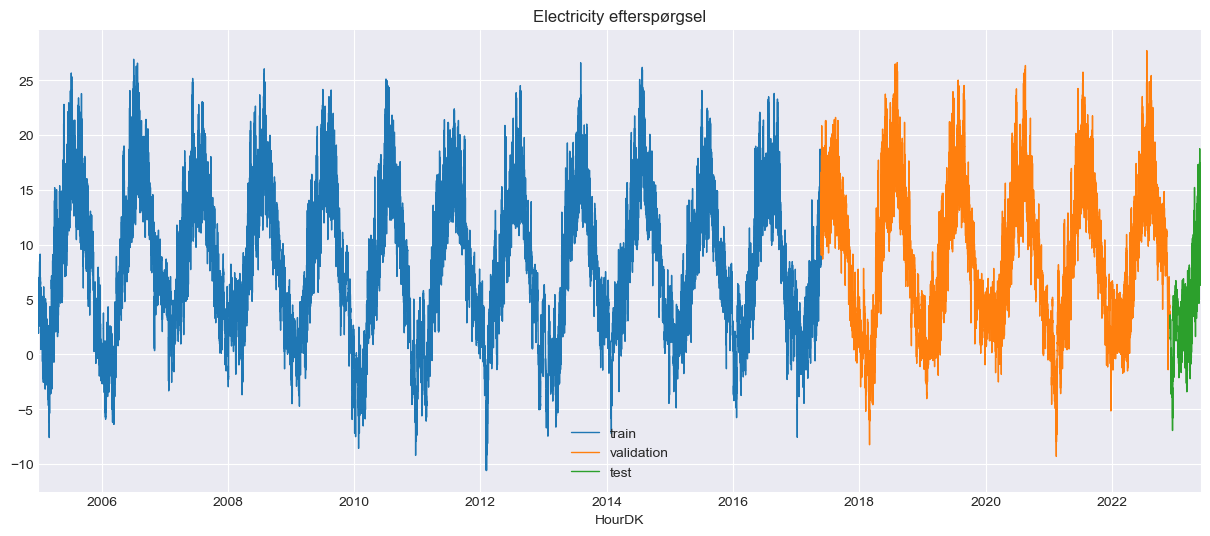

In [9]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data_train.temp_max_past1h.plot(ax=ax, label='train', linewidth=1)
data_val.temp_max_past1h.plot(ax=ax, label='validation', linewidth=1)
data_test.temp_max_past1h.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity efterspørgsel')
ax.legend();

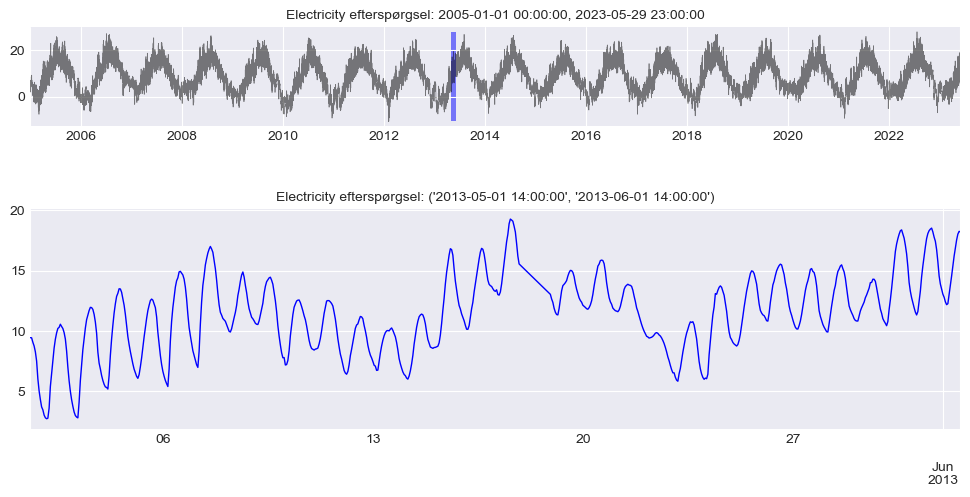

In [13]:
# Zooming time series chart
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')
fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[4:, :])
data.temp_max_past1h.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.temp_max_past1h)
max_y = max(data.temp_max_past1h)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]].temp_max_past1h.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Electricity efterspørgsel: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Electricity efterspørgsel: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

## Årlig, ugentlig og daglig seasonality

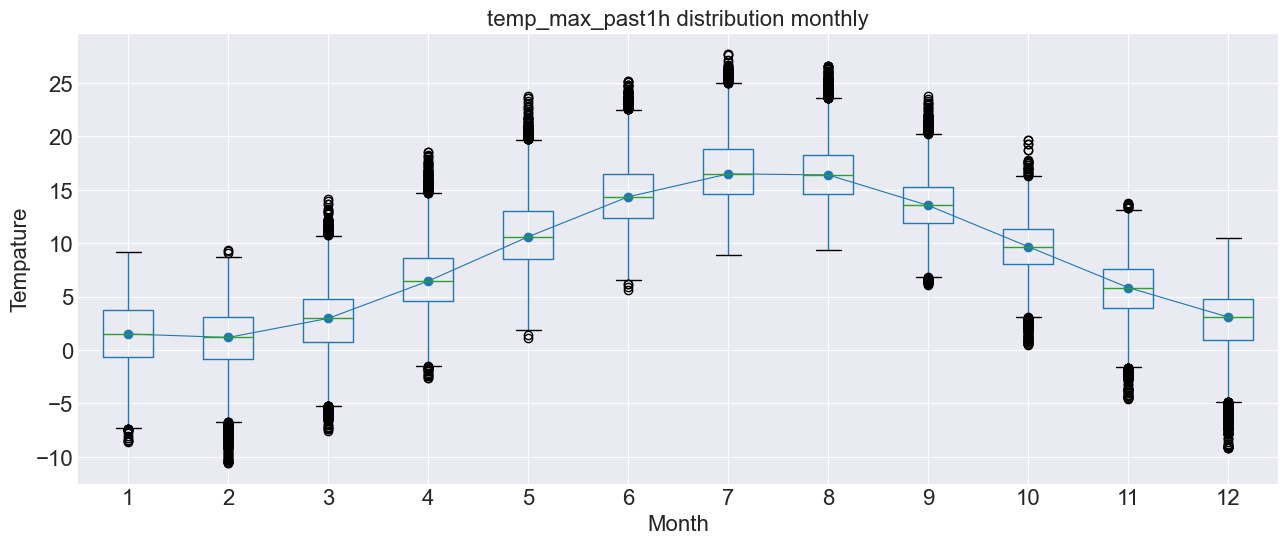

In [15]:
# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data['month'] = data.index.month
data.boxplot(column='temp_max_past1h', by='month', ax=ax,)
data.groupby('month')['temp_max_past1h'].median().plot(style='o-', linewidth=0.8, ax=ax, fontsize=16)
ax.set_ylabel('Tempature' ,fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.set_title('temp_max_past1h distribution monthly', fontsize=16)
fig.suptitle('');

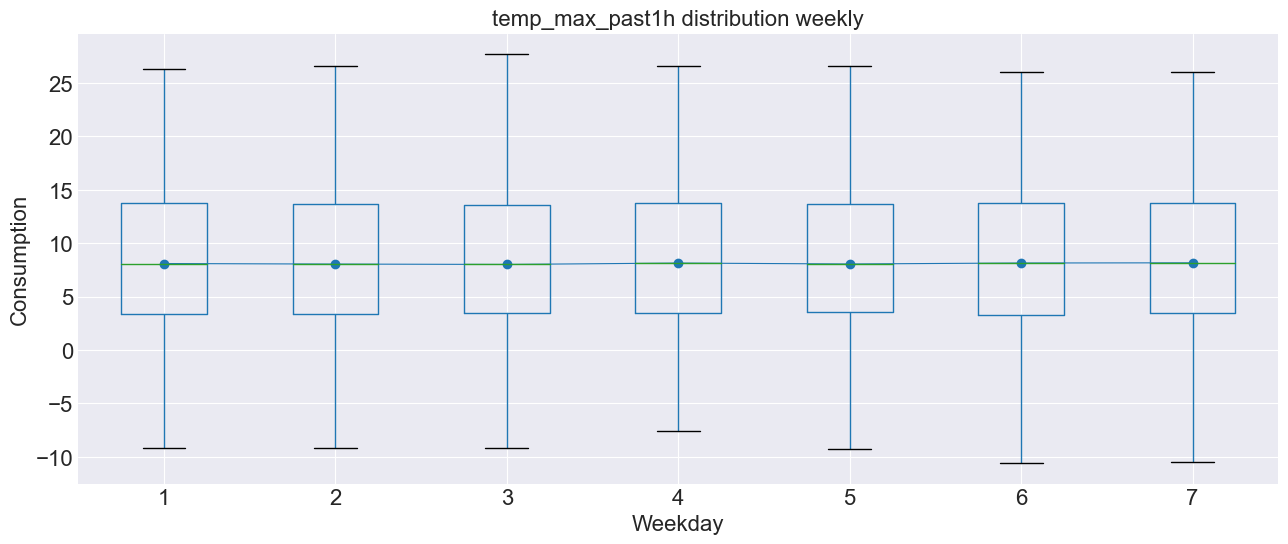

In [16]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='temp_max_past1h', by='week_day', ax=ax)
data.groupby('week_day')['temp_max_past1h'].median().plot(style='o-', linewidth=0.8, ax=ax, fontsize=16)
ax.set_ylabel('Tempature', fontsize=16)
ax.set_xlabel('Weekday', fontsize=16)
ax.set_title('temp_max_past1h distribution weekly', fontsize=16)
fig.suptitle('');

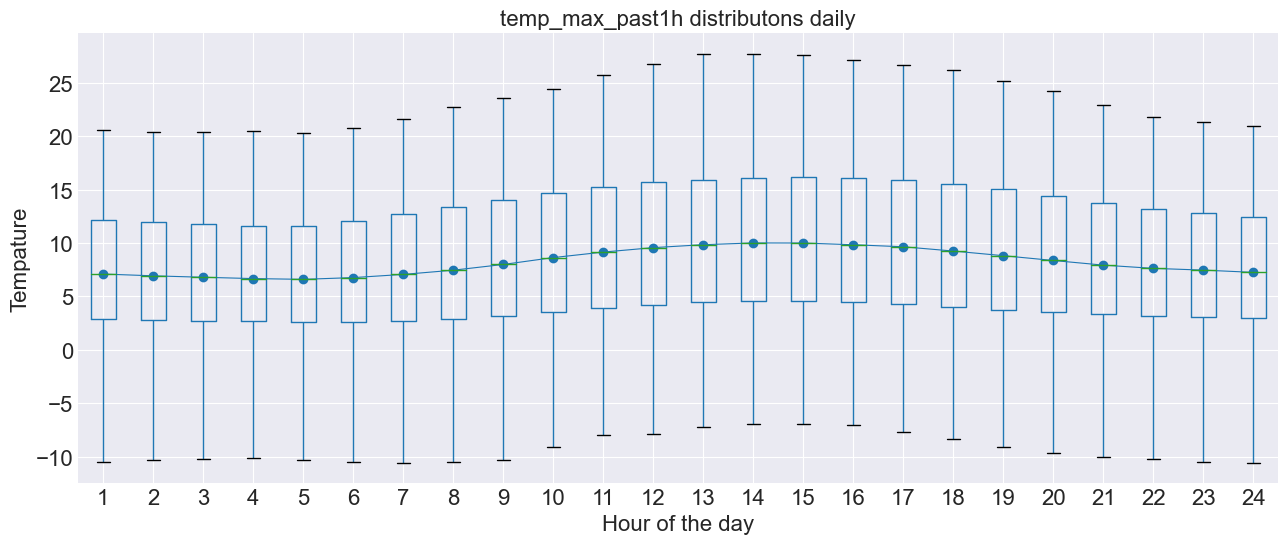

In [18]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='temp_max_past1h', by='hour_day', ax=ax)
data.groupby('hour_day')['temp_max_past1h'].median().plot(style='o-', linewidth=0.8, ax=ax,  fontsize=16)
ax.set_ylabel('Tempature', fontsize=16)
ax.set_xlabel('Hour of the day', fontsize=16)
ax.set_title('temp_max_past1h distributons daily', fontsize=16)
fig.suptitle('');

## Autocorrelations plots

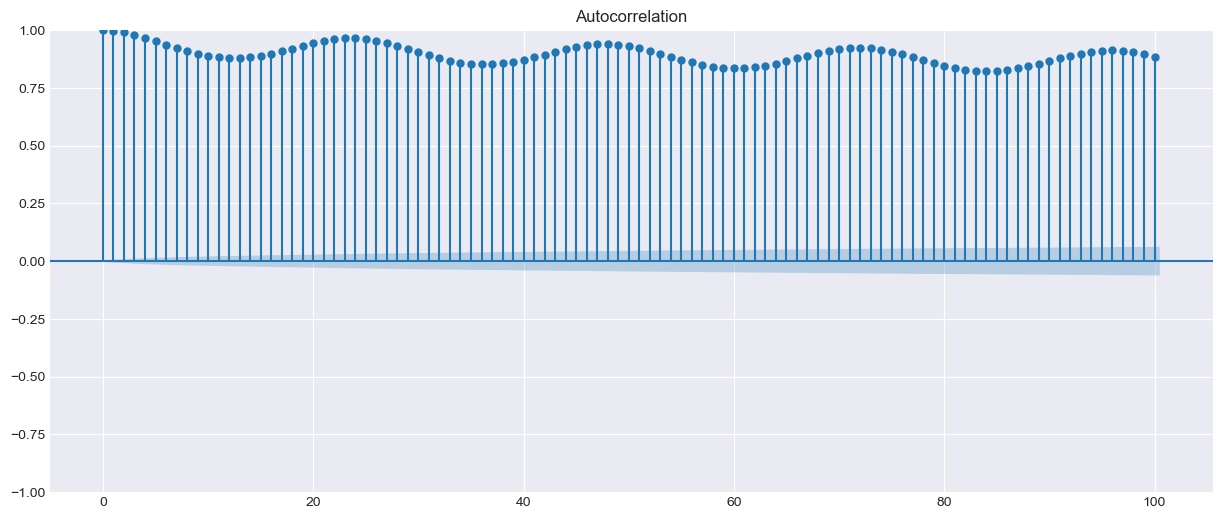

In [29]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(data.temp_max_past1h, ax=ax, lags=100)
plt.show()

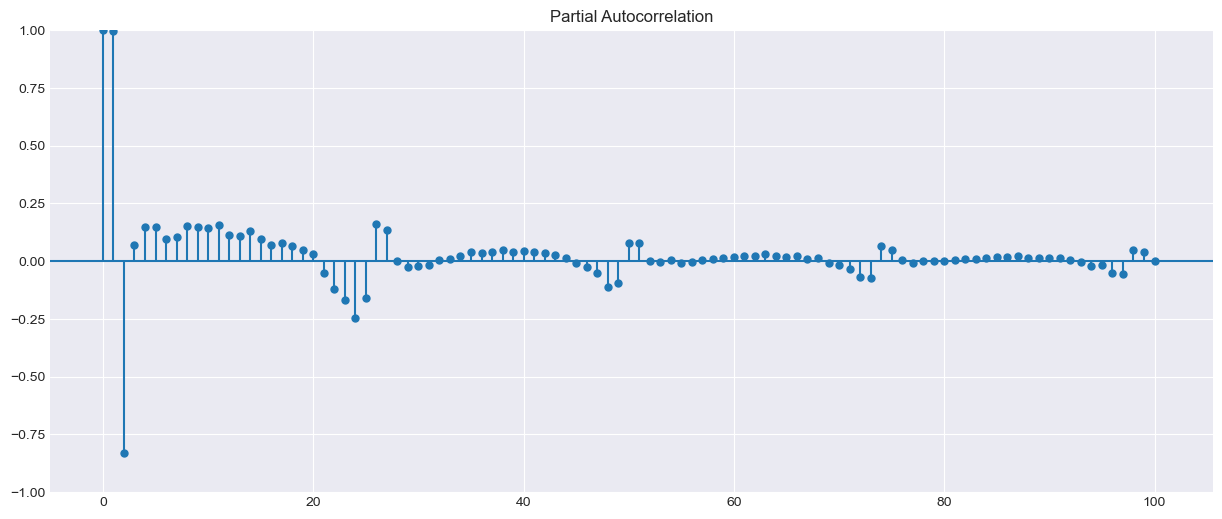

In [30]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(data.temp_max_past1h, ax=ax, lags=100)
plt.show()

In [32]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_validation, 'temp_max_past1h'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-01 00:00:00'), Timestamp('2022-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-10 10:40:26 
Last fit date: 2023-08-10 10:40:26 
Skforecast version: 0.9.0 
Python version: 3.9.7 
Forecaster id: None 

In [34]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['temp_max_past1h'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          verbose            = True,
                          show_progress      = True
                    )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 157032
Number of observations used for backtesting: 4320
    Number of folds: 180
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-01 00:00:00 -- 2022-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-02 00:00:00 -- 2022-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-03 00:00:00 -- 2022-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 2022-12-04 00:00:00 -- 2022-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2005-01-01 00:00:00 -- 2022-11-30 23:00:00  (n=157032)
    Validation: 20

  0%|          | 0/180 [00:00<?, ?it/s]

Backtest error: 1.0728424920407773


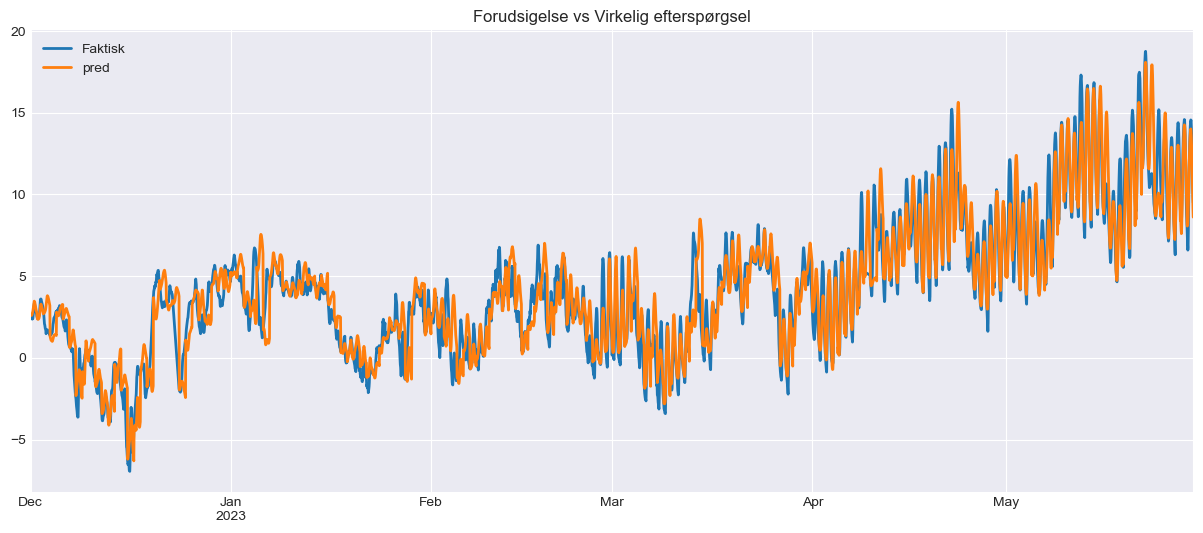

In [38]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Forudsigelse vs Virkelig efterspørgsel')
ax.legend();

# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

In [39]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'temp_max_past1h'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'alpha': 27.825594022071257}
  Backtesting metric: 0.9714514368521616



In [40]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_absolute_error,alpha
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 27.825594022071257},0.971451,27.825594
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 3.593813663804626},0.971762,3.593814
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},0.972836,0.464159
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},0.973015,0.059948
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},0.973040,0.007743
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},0.973043,0.001000
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},0.981240,27.825594
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},0.981416,0.001000
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},0.981419,0.007743
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},0.981443,0.059948


  0%|          | 0/180 [00:00<?, ?it/s]

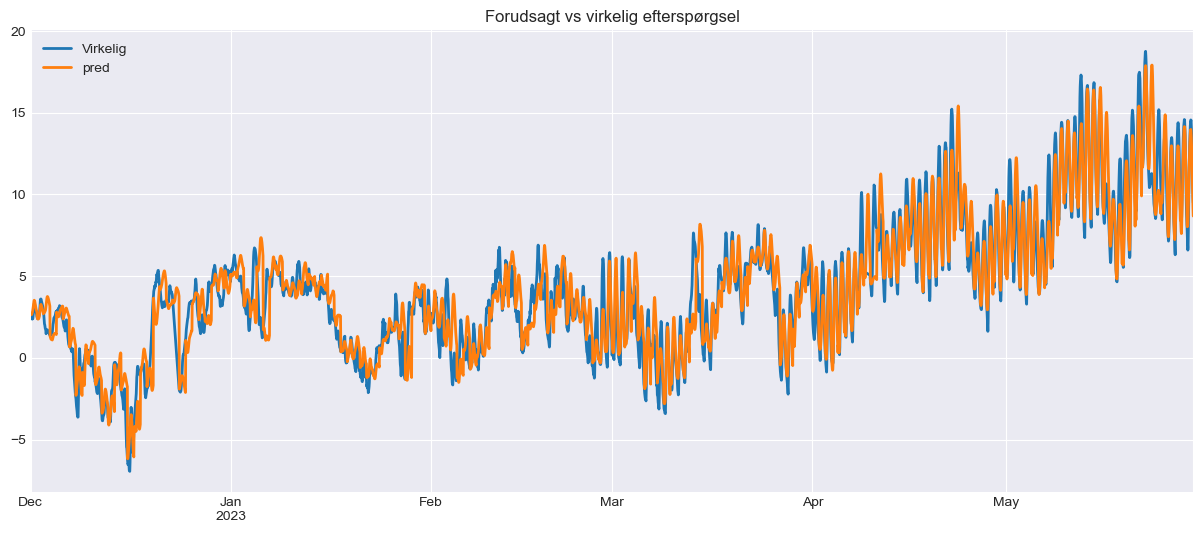

In [47]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['temp_max_past1h'],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'temp_max_past1h'].plot(linewidth=2, label='Virkelig', ax=ax)
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Forudsagt vs virkelig efterspørgsel')
ax.legend();

In [46]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 4.4375219984690295


  0%|          | 0/1 [00:00<?, ?it/s]

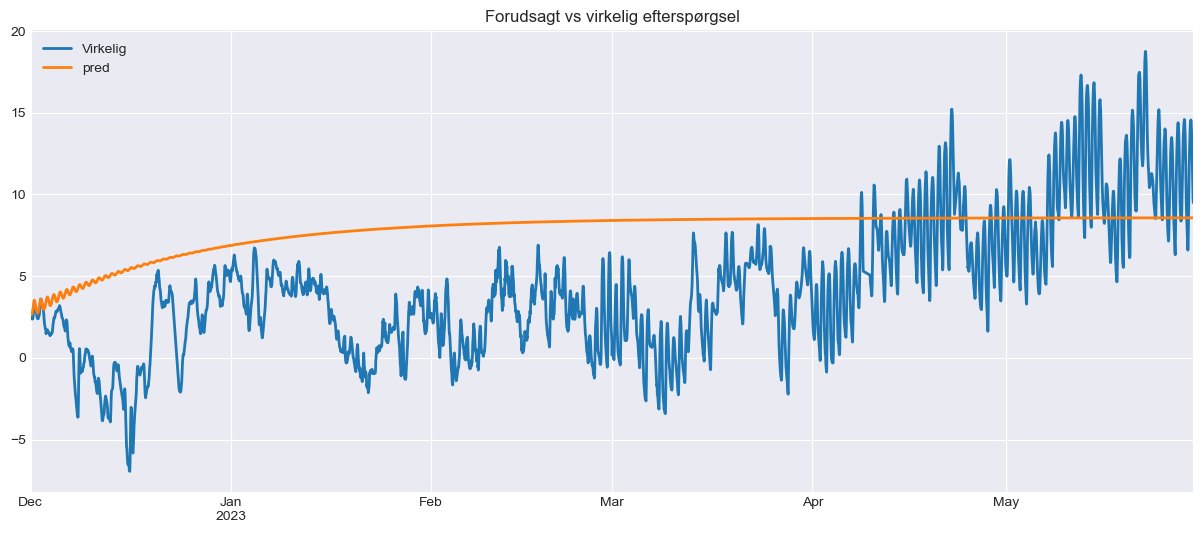

In [49]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['temp_max_past1h'],
                          steps              = 5040,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(15, 6))
data.loc[predictions.index, 'temp_max_past1h'].plot(linewidth=2, label='Virkelig', ax=ax)
predictions.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Forudsagt vs virkelig efterspørgsel')
ax.legend();

## Aggregering

Vi har nu vores datasæt for timeligt dette skal kopieres til 3 nye dataframes, for de 3 aggreveringer

* `temp_daily`
* `temp_weekly`
* `temp_monthly`

In [52]:
# Dagligt data
temp_daily = temp.resample('D').agg(
    {'temp_max_past1h': 'mean', })
print(temp_daily)

# Ugentligt data
temp_weekly =temp.resample('W').agg(
    {'temp_max_past1h': 'mean', })
temp_weekly.index = temp_weekly.index.to_period('W')
print(temp_weekly)

# Månedligt data
temp_monthly =temp.resample('M').agg(
    {'temp_max_past1h': 'mean', })
temp_monthly.index = temp_monthly.index.to_period('M')
print(temp_monthly)

            temp_max_past1h
HourDK                     
2005-01-01         3.517958
2005-01-02         3.949927
2005-01-03         4.343384
2005-01-04         6.551546
2005-01-05         4.758494
...                     ...
2023-05-25        11.163726
2023-05-26        10.481420
2023-05-27        10.866656
2023-05-28        11.418121
2023-05-29        11.152402

[6723 rows x 1 columns]
                       temp_max_past1h
HourDK                                
2004-12-27/2005-01-02         3.733943
2005-01-03/2005-01-09         5.932621
2005-01-10/2005-01-16         4.733791
2005-01-17/2005-01-23         2.863935
2005-01-24/2005-01-30         0.147573
...                                ...
2023-05-01/2023-05-07         7.468537
2023-05-08/2023-05-14        11.968612
2023-05-15/2023-05-21        10.489866
2023-05-22/2023-05-28        11.636457
2023-05-29/2023-06-04        11.152402

[962 rows x 1 columns]
         temp_max_past1h
HourDK                  
2005-01         3.473477
2005-

In [53]:
# Find den første mandag i eller efter 2005-01-01
first_monday = next((idx.start_time for idx in temp_weekly.index if idx.start_time.weekday() == 0 and idx.start_time >= pd.Timestamp('2005-01-01')), None)

# Find den sidste søndag i eller før 2023-05-29
last_sunday = next((idx.end_time for idx in reversed(temp_weekly.index) if idx.end_time.weekday() == 6 and idx.end_time <= pd.Timestamp('2023-05-29')), None)

# Find den første uge der indeholder first_monday
first_full_week = next((idx for idx in temp_weekly.index if idx.start_time == first_monday), None)

# Find den sidste uge der indeholder last_sunday
last_full_week = next((idx for idx in reversed(temp_weekly.index) if idx.end_time == last_sunday), None)

# Skær det ufuldstændige data fra begyndelsen og slutningen af dit datasæt
temp_weekly = temp_weekly.loc[first_full_week:last_full_week]
print(temp_weekly)

                       temp_max_past1h
HourDK                                
2005-01-03/2005-01-09         5.932621
2005-01-10/2005-01-16         4.733791
2005-01-17/2005-01-23         2.863935
2005-01-24/2005-01-30         0.147573
2005-01-31/2005-02-06         2.712043
...                                ...
2023-04-24/2023-04-30         6.552692
2023-05-01/2023-05-07         7.468537
2023-05-08/2023-05-14        11.968612
2023-05-15/2023-05-21        10.489866
2023-05-22/2023-05-28        11.636457

[960 rows x 1 columns]


In [54]:
end_train = '2017-05-01'
end_validation = '2022-11-30'

data_train_daily = temp_daily.loc[: end_train, :].copy()
data_val_daily   = temp_daily.loc[end_train:end_validation, :].copy()
data_test_daily  = temp_daily.loc[end_validation:, :].copy()

data_train_weekly = temp_weekly.loc[: end_train, :].copy()
data_val_weekly   = temp_weekly.loc[end_train:end_validation, :].copy()
data_test_weekly  = temp_weekly.loc[end_validation:, :].copy()

data_train_monthly = temp_monthly.loc[: end_train, :].copy()
data_val_monthly   = temp_monthly.loc[end_train:end_validation, :].copy()
data_test_monthly  = temp_monthly.loc[end_validation:, :].copy()

print(f"Train dates for daily       : {data_train_daily.index.min()} - {data_train_daily.index.max()}  (n={len(data_train_daily)})")
print(f"Validation dates for daily  : {data_val_daily.index.min()} - {data_val_daily.index.max()}  (n={len(data_val_daily)})")
print(f"Test dates for daily        : {data_test_daily.index.min()} - {data_test_daily.index.max()}  (n={len(data_test_daily)})")
print("\n")
print(f"Train dates for weekly      : {data_train_weekly.index.min()} - {data_train_weekly.index.max()}  (n={len(data_train_weekly)})")
print(f"Validation dates for weekly : {data_val_weekly.index.min()} - {data_val_weekly.index.max()}  (n={len(data_val_weekly)})")
print(f"Test dates for weekly       : {data_test_weekly.index.min()} - {data_test_weekly.index.max()}  (n={len(data_test_weekly)})")
print("\n")
print(f"Train dates for monthly     : {data_train_monthly.index.min()} - {data_train_monthly.index.max()}  (n={len(data_train_monthly)})")
print(f"Validation dates for monthly: {data_val_monthly.index.min()} - {data_val_monthly.index.max()}  (n={len(data_val_monthly)})")
print(f"Test dates for monthly      : {data_test_monthly.index.min()} - {data_test_monthly.index.max()}  (n={len(data_test_monthly)})")

Train dates for daily       : 2005-01-01 00:00:00 - 2017-05-01 00:00:00  (n=4504)
Validation dates for daily  : 2017-05-01 00:00:00 - 2022-11-30 00:00:00  (n=2040)
Test dates for daily        : 2022-11-30 00:00:00 - 2023-05-29 00:00:00  (n=181)


Train dates for weekly      : 2005-01-03/2005-01-09 - 2017-05-01/2017-05-07  (n=644)
Validation dates for weekly : 2017-05-01/2017-05-07 - 2022-11-28/2022-12-04  (n=292)
Test dates for weekly       : 2022-11-28/2022-12-04 - 2023-05-22/2023-05-28  (n=26)


Train dates for monthly     : 2005-01 - 2017-05  (n=149)
Validation dates for monthly: 2017-05 - 2022-11  (n=67)
Test dates for monthly      : 2022-11 - 2023-05  (n=7)


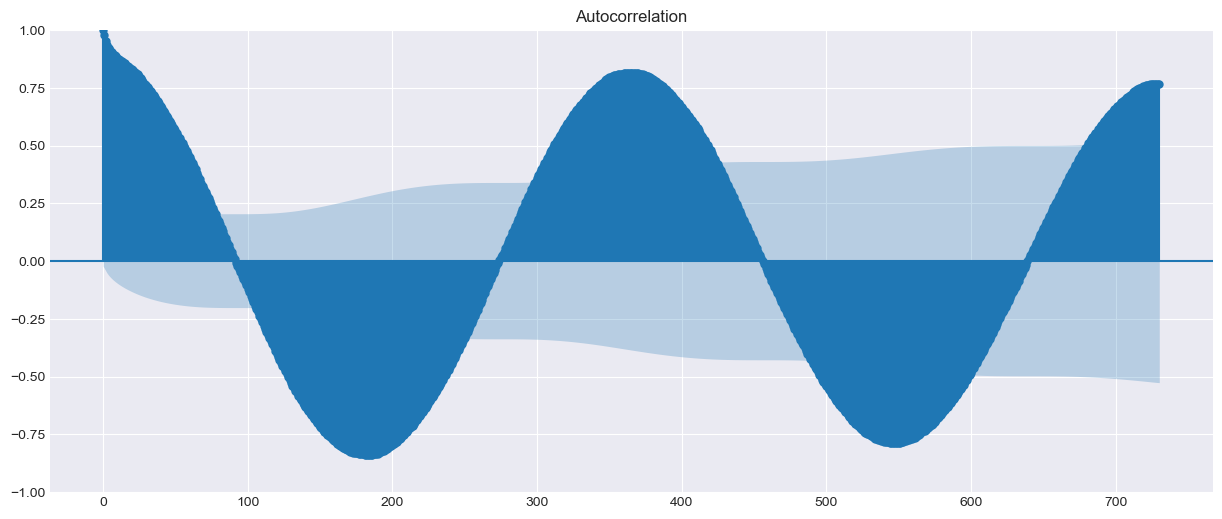

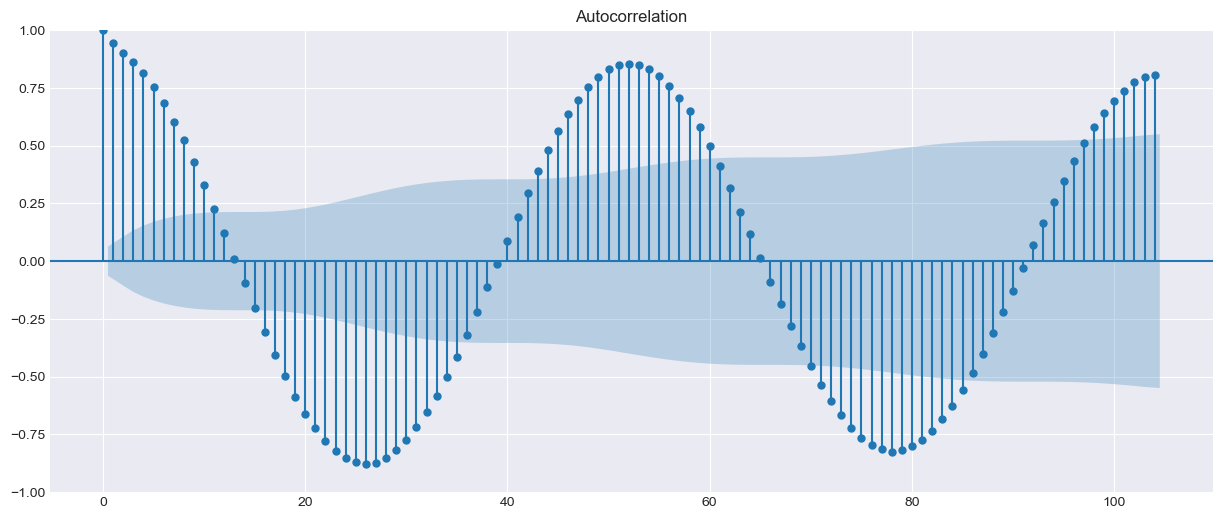

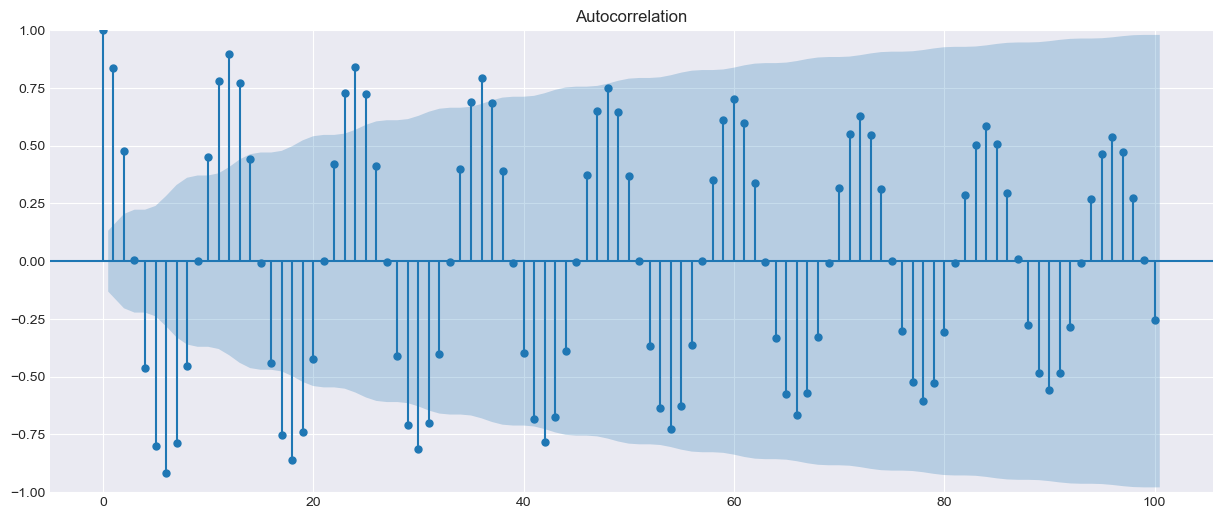

In [56]:
# Daglige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(temp_daily.temp_max_past1h, ax=ax, lags=365*2)
plt.show()

# Ugentlige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(temp_weekly.temp_max_past1h, ax=ax, lags=52*2)
plt.show()

# Månedlige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(temp_monthly.temp_max_past1h, ax=ax, lags=100)
plt.show()

## Recursiv multi-step forudsigelse

En rekursiv autoregressions model (ForecasterAutoreg) er lavet og trænet fra en lineær regressions model med en Ridge penalty og et tidsvindue på lags der er valgt ud fra ACF plotsne. Dette betyder at for hver forudsigelse, er efterspørgselsværdien for de tidligere antal lags observationer brugt som en prædikator.

In [59]:
# Create and train forecaster for daily
# ==============================================================================
forecaster_daily = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 365,
                 transformer_y = StandardScaler()
             )

forecaster_daily.fit(y=temp_daily.loc[:end_validation, 'temp_max_past1h'])
print(forecaster_daily)

# Create and train forecaster for weekly
# ==============================================================================
forecaster_weekly = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 52,
                 transformer_y = StandardScaler()
             )

forecaster_weekly.fit(y=temp_weekly.loc[:end_validation, 'temp_max_past1h'])
print(forecaster_weekly)

# Create and train forecaster for monthly
# ==============================================================================
forecaster_monthly = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 12,
                 transformer_y = StandardScaler()
             )

forecaster_monthly.fit(y=temp_monthly.loc[:end_validation, 'temp_max_past1h'])
print(forecaster_monthly)

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


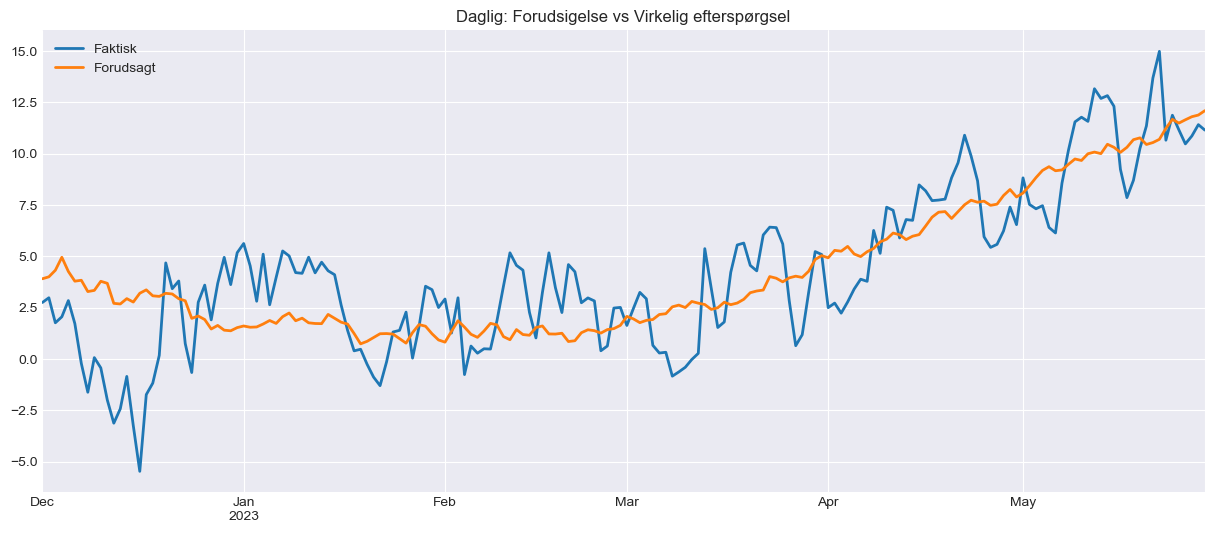

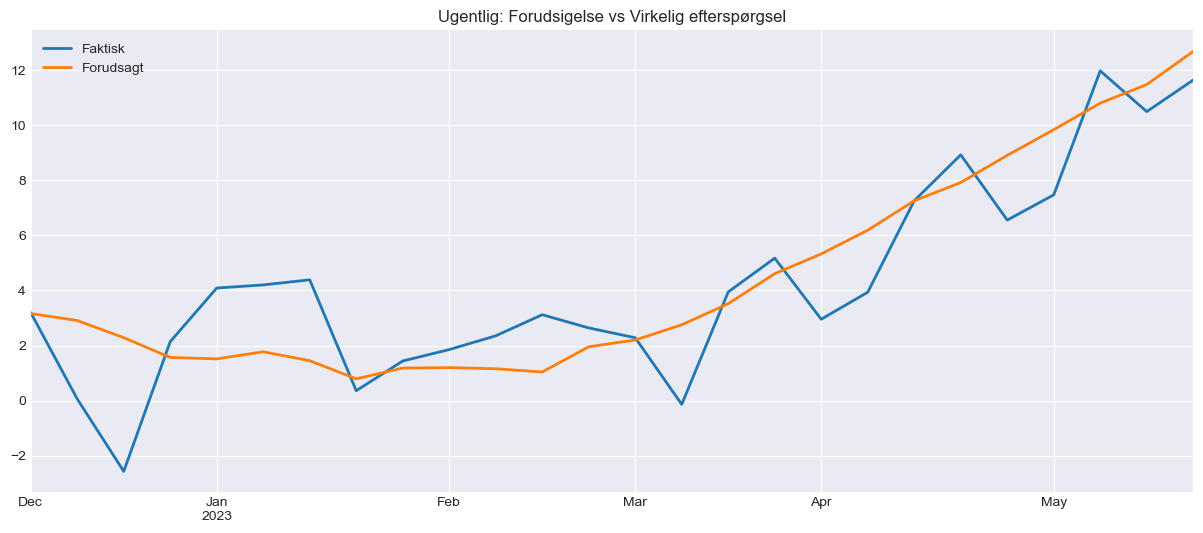

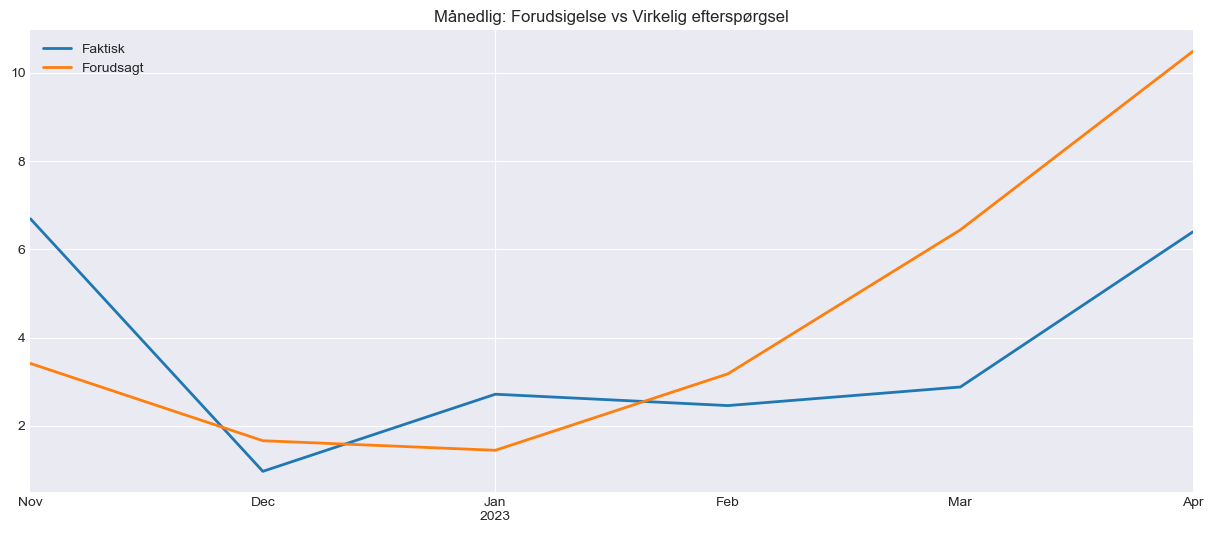

In [60]:
# Forudsig et halvt år frem for daglig data
predictions_daily = forecaster_daily.predict(steps=180)

# Forudsig et halvt år frem for ugentlig data
predictions_weekly = forecaster_weekly.predict(steps=26)

# Forudsig et halvt år frem for månedlig data
predictions_monthly = forecaster_monthly.predict(steps=6)

# Dette antager, at du vil forudsige de næste 26 uger fra slutningen af dit valideringssæt
start_date = pd.Period('2022-11-28/2022-12-04', 'W-SUN')
prediction_dates = [start_date + i for i in range(26)]
predictions_weekly.index = prediction_dates

# The target is to predict the next 7 months from the end of your validation set
start_date = pd.Period('2022-11', 'M')
prediction_dates = [start_date + i for i in range(6)]
predictions_monthly.index = prediction_dates

# Tegn daglige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
temp_daily.loc[predictions_daily.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_daily.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Daglig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

# Tegn ugentlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
temp_weekly.loc[predictions_weekly.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_weekly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Ugentlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

# Tegn månedlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
temp_monthly.loc[predictions_monthly.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_monthly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Månedlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

$$
RMSE = \sqrt{\frac{\sum_{i=1}^{n}(Y_i-\hat{Y_i})^2}{n}} 
$$

In [96]:
# save sum of test and predictions:
#====================== daily =======================================
# Calculate the sum of predictions and test data
sum_pred_daily = predictions_daily
sum_test_daily = data_test_daily['temp_max_past1h'][1:]

# Calculate RMSE
RMSE_daily = np.sqrt(np.mean((np.array(sum_test_daily) - np.array(sum_pred_daily))**2))
print(RMSE_daily)
print(f"Backtest RMSE weekly: {RMSE_daily:.2f}")


#====================== weekly =======================================
sum_pred_weekly=predictions_weekly
sum_test_weekly=data_test_weekly['temp_max_past1h']


RMSE_weekly = np.sqrt(np.mean((np.array(sum_pred_weekly) - np.array(sum_test_weekly))**2))
print(f"Backtest pct error weekly: {RMSE_weekly:.2f}")

#====================== monthly =======================================
sum_pred_monthly=predictions_monthly
sum_test_monthly=data_test_monthly['temp_max_past1h'][1:]

RMSE_monthly = np.sqrt(np.mean((np.array(sum_pred_monthly) - np.array(sum_test_monthly))**2))
print(f"Backtest pct error monthly: {RMSE_monthly:.2f}")

2.360822836462694
Backtest RMSE weekly: 2.36
Backtest pct error weekly: 1.91
Backtest pct error monthly: 1.17


# Hyperparameter tuning

Den trænede `ForecasterAutoreg` object bruger de første 365, 52 og 12 antal lags og en ridge model med defualt hyperparametre. Der er dog ungen grund til at disse værdier skulle være de mest passende.

For at identificere den bedste combination af lags og hyperparameter er Grid Search med validering Backtesting brugt. Denne process består af at træne en model med forskellgie kombination af parametre og lags og så evaluere dens forudsigelses kapacitet. i denne søgnings proces er det vigtigt at evaluere modelen ved at bruge validerings data og ikke inkludere test data, som kun er brugt til at evaluere den endelige model.

## Daglig


In [98]:
# Hyperparameter Grid search for daily data
# ==============================================================================
forecaster_daily = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 7, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid_daily =[365-36*i for i in range(10)]

# Regressor's hyperparameters
param_grid_daily = {'alpha': np.logspace(-3, 5, 10)}

results_grid_daily = grid_search_forecaster(
                   forecaster         = forecaster_daily,
                   y                  = temp_daily.loc[:end_validation, 'temp_max_past1h'],
                   steps              = 7,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid_daily,
                   lags_grid          = lags_grid_daily,
                   initial_train_size = len(temp_daily[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 100.


lags grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149] 
  Parameters: {'alpha': 27.825594022071257}
  Backtesting metric: 1.5209483444409095



In [106]:
# Create and train the best model for daily data
# ==============================================================================
forecaster_daily_best = ForecasterAutoreg(
    regressor=Ridge(alpha=27.825594022071257, random_state=123),
    lags=list(range(1, 366)),
    transformer_y=StandardScaler()
)

forecaster_daily_best.fit(y=temp_daily['temp_max_past1h'])

Backtest RMSE weekly: 2.39


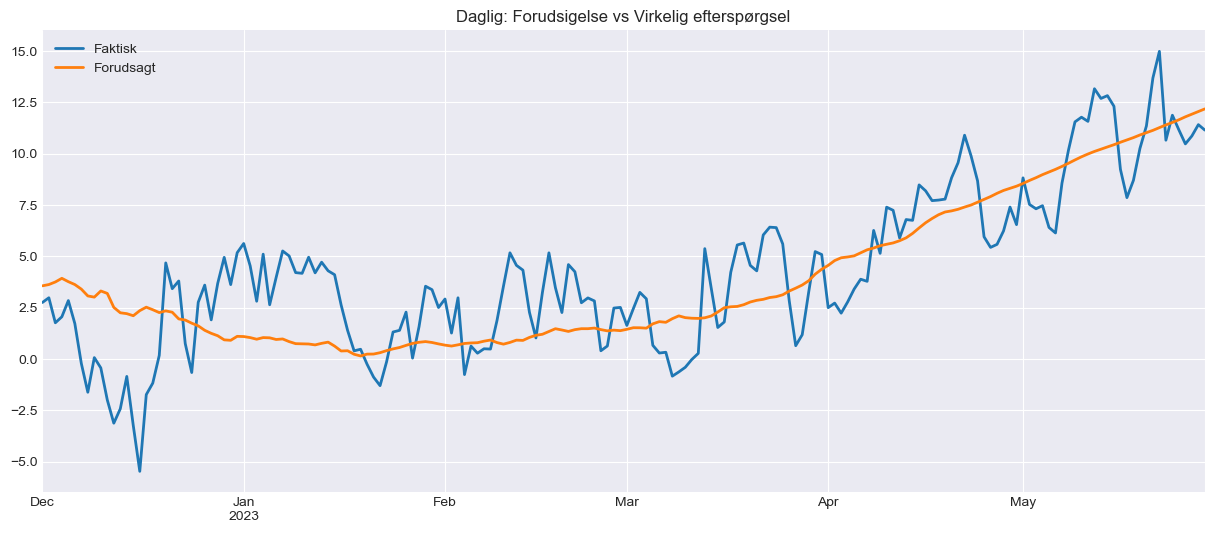

In [108]:
# Forudsig et halvt år frem for daglig data
predictions_daily = forecaster_daily.predict(steps=180)

# Tegn daglige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
temp_daily.loc[predictions_daily.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_daily.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Daglig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

#====================== daily =======================================
# Calculate the sum of predictions and test data
sum_pred_daily = predictions_daily
sum_test_daily = data_test_daily['temp_max_past1h'][1:]

# Calculate RMSE
RMSE_daily = np.sqrt(np.mean((np.array(sum_test_daily) - np.array(sum_pred_daily))**2))
print(f"Backtest RMSE weekly: {RMSE_daily:.2f}")

## Ugenlig data

In [105]:
# Create a copy of the original dataframe and convert the index to timestamp
temp_weekly_copy = temp_weekly.copy()
temp_weekly_copy.index = temp_weekly_copy.index.to_timestamp()

# Hyperparameter Grid search for weekly data
# ==============================================================================
forecaster_weekly = ForecasterAutoreg(
    regressor     = Ridge(random_state=123),
    lags          = 52, # This value will be replaced in the grid search
    transformer_y = StandardScaler()
)

# Lags used as predictors
lags_grid_weekly = [52-36*i for i in range(10) if 52-36*i >= 1]

# Regressor's hyperparameters
param_grid_weekly = {'alpha': np.logspace(-3, 5, 10)}

results_grid_weekly = grid_search_forecaster(
    forecaster         = forecaster_weekly,
    y                  = temp_weekly_copy.loc[:end_validation, 'temp_max_past1h'],
    steps              = 26, # Assuming we are forecasting 6 months (26 weeks) ahead
    metric             = 'mean_absolute_error',
    param_grid         = param_grid_weekly,
    lags_grid          = lags_grid_weekly,
    initial_train_size = len(temp_weekly_copy[:end_train]),
    refit              = False,
    return_best        = True,
    verbose            = False
)

Number of models compared: 20.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 1.5261097313793544



In [110]:
# Create and train forecaster for weekly
# ==============================================================================
forecaster_weekly = ForecasterAutoreg(
                 regressor     = Ridge(alpha=215.44346900318823,random_state=123),
                 lags          = list(range(1, 53)),
                 transformer_y = StandardScaler()
             )

forecaster_weekly.fit(y=temp_weekly.loc[:end_validation, 'temp_max_past1h'])

C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


Backtest pct error weekly: 1.97


C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


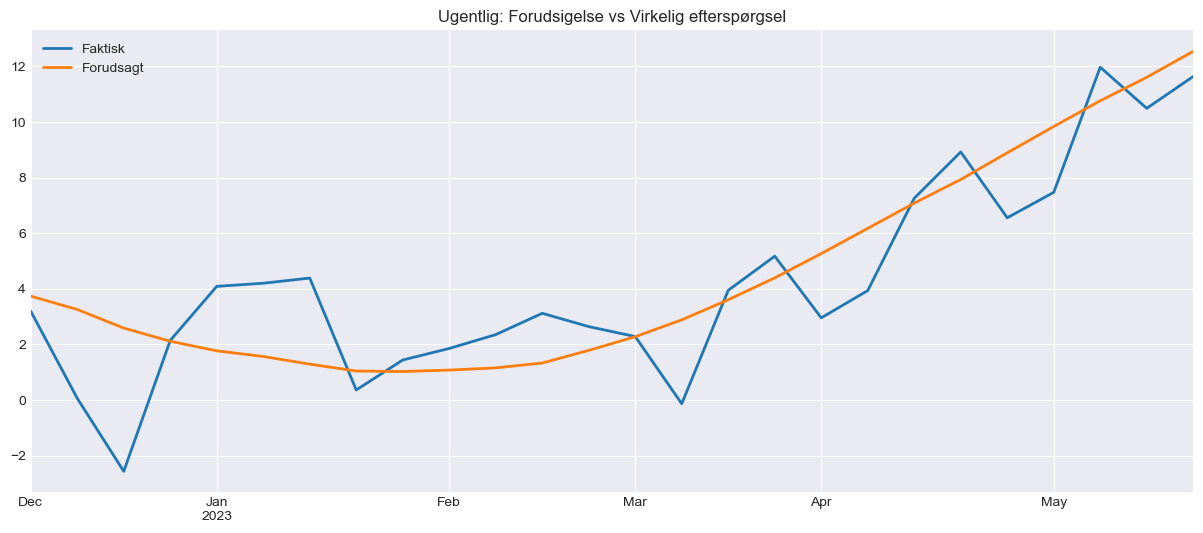

In [113]:
# Forudsig et halvt år frem for ugentlig data
predictions_weekly = forecaster_weekly.predict(steps=26)

# Dette antager, at du vil forudsige de næste 26 uger fra slutningen af dit valideringssæt
start_date = pd.Period('2022-11-28/2022-12-04', 'W-SUN')
prediction_dates = [start_date + i for i in range(26)]
predictions_weekly.index = prediction_dates

# Tegn ugentlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
temp_weekly.loc[predictions_weekly.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_weekly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Ugentlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

#====================== weekly =======================================
sum_pred_weekly=predictions_weekly
sum_test_weekly=data_test_weekly['temp_max_past1h']


RMSE_weekly = np.sqrt(np.mean((np.array(sum_pred_weekly) - np.array(sum_test_weekly))**2))
print(f"Backtest pct error weekly: {RMSE_weekly:.2f}")

## Månedlig

In [120]:
# Prepare a copy of the data for grid search (convert PeriodIndex to Timestamp)
monthly_gs = temp_monthly.copy()
monthly_gs.index = monthly_gs.index.to_timestamp()

# Create forecaster
forecaster_monthly = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 12, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid_monthly = [12-i for i in range(10) if 12-i >= 1]

# Regressor's hyperparameters
param_grid_monthly = {'alpha': np.logspace(-3, 5, 10)}

results_grid_monthly = grid_search_forecaster(
                   forecaster         = forecaster_monthly,
                   y                  = monthly_gs.loc[:end_validation, 'temp_max_past1h'],
                   steps              = 6, # Assuming we are forecasting 6 months ahead
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid_monthly,
                   lags_grid          = lags_grid_monthly,
                   initial_train_size = len(monthly_gs[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 100.


lags grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 1.1611077148340359



In [124]:
# Create and train forecaster for weekly
# ==============================================================================
forecaster_monthly = ForecasterAutoreg(
                 regressor     = Ridge(alpha=3.593813663804626,random_state=123),
                 lags          = list(range(1, 13)),
                 transformer_y = StandardScaler()
             )

forecaster_monthly.fit(y=temp_monthly.loc[:end_validation, 'temp_max_past1h'])

C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:790: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


Backtest pct error monthly: 1.17


C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\madsh\anaconda3\lib\site-packages\skforecast\utils\utils.py:852: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


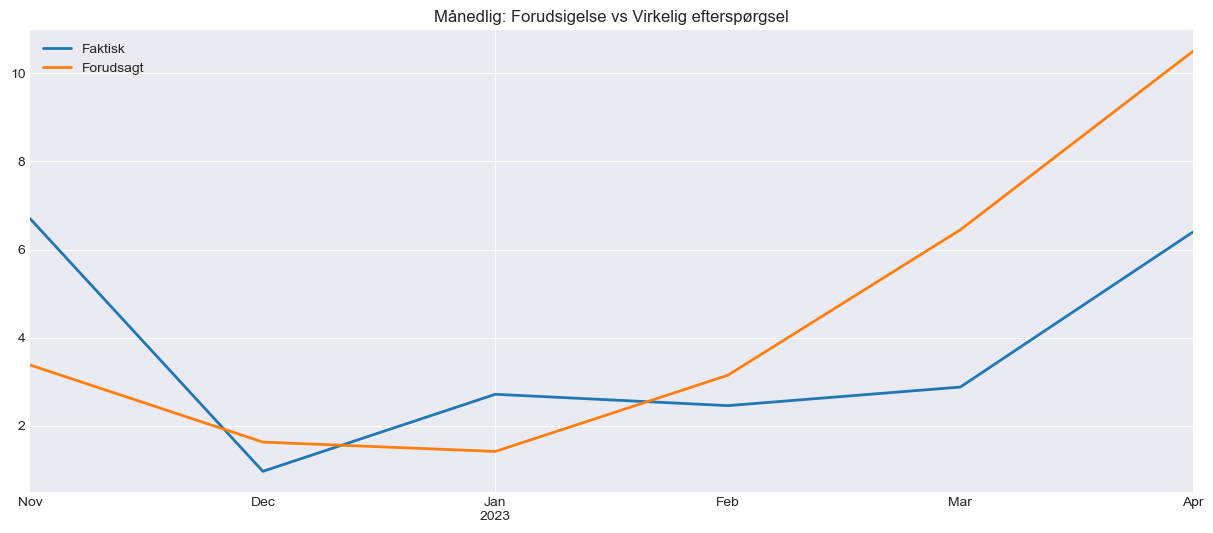

In [126]:
# Forudsig et halvt år frem for månedlig data
predictions_monthly = forecaster_monthly.predict(steps=6)

# The target is to predict the next 6 months from the end of your validation set
start_date = pd.Period('2022-11', 'M')
prediction_dates = [start_date + i for i in range(6)]
predictions_monthly.index = prediction_dates

# Tegn månedlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
temp_monthly.loc[predictions_monthly.index, 'temp_max_past1h'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_monthly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Månedlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

#====================== monthly =======================================
sum_pred_monthly=predictions_monthly
sum_test_monthly=data_test_monthly['temp_max_past1h'][1:]

RMSE_monthly = np.sqrt(np.mean((np.array(sum_pred_monthly) - np.array(sum_test_monthly))**2))
print(f"Backtest pct error monthly: {RMSE_monthly:.2f}")